> # 6 알고리즘 체인과 파이프라인

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler

In [8]:
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

# 훈련 데이터의 최솟값, 최댓값을 계산
scaler = MinMaxScaler().fit(X_train)

# 훈련 데이터의 스케일 조정
X_train_scaled = scaler.transform(X_train)

svm = SVC()
svm.fit(X_train_scaled, y_train)
X_test_scaled = scaler.transform(X_test)
print("테스트 점수: {:.2f}".format(svm.score(X_test_scaled, y_test)))

테스트 점수: 0.95


C:\Users\JH\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


## 6.1 데이터 전처리와 매개변수 선택

In [9]:
from sklearn.model_selection import GridSearchCV

# 에를 위한 코드
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
print("최상의 교차 검증 정확도: {:.2f}".format(grid.best_score_))
print("테스트 세트 점수: {:.2f}".format(grid.score(X_test_scaled, y_test)))
print("최적의 매개변수: ", grid.best_params_)

최상의 교차 검증 정확도: 0.98
테스트 세트 점수: 0.97
최적의 매개변수:  {'C': 1, 'gamma': 1}


- 하지만 이 예시에서의 오류는 검증 폴드로 쓰일 데이터까지 한번에 스케일링 되었다는 것

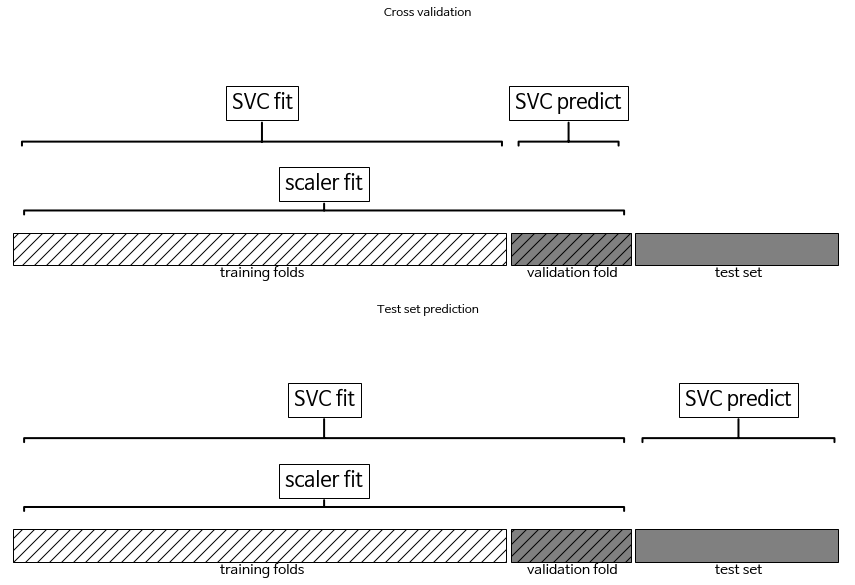

In [10]:
mglearn.plots.plot_improper_processing()

- 때문에 교차 검증의 분할 방식은 모델이 새 데이터를 만났을 때 올바로 반영X
- 검증 폴드 데이터의 정보가 모델 구축 과정에서 이미 누설되었다는 말임
- 낙관적인 결과가 만들어지게 됨
- 교차 검증의 분할이 모든 전처리 과정보다 앞서 이루어져야 함
- -> 파이프라인의 필요성

## 6.2 파이프라인 구축하기

#### SVM의 예

- 각 단계를 리스트로 전달하여 파이프라인 객체를 만듬
- 각 단계는 추정기의 객체와 임의의 이름으로 구성된 튜플

In [11]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])

In [13]:
pipe.fit(X_train, y_train)
print("테스트 점수: {:.2f}".format(pipe.score(X_test, y_test)))

테스트 점수: 0.95


C:\Users\JH\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


- 코드가 줄어드는 장점
- cross_val_score나 GridSearchCV를 하나의 추정기처럼 사용할 수 있음

## 6.3 그리드 서치에 파이프라인 적용하기

- 각 매개변수가 파이프라인의 어떤 단계에 속한 것인지 알려줘야 함
- 파이프라인용 매개변수 그리드는 단계 이름과 매개변수 이름을 _ 두개로 연결해 만듬

In [14]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

In [16]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("최상의 교차 검증 정확도: {:.2f}".format(grid.best_score_))
print("테스트 세트 점수: {:.2f}".format(grid.score(X_test, y_test)))
print("최적의 매개변수: {}".format(grid.best_params_))

최상의 교차 검증 정확도: 0.98
테스트 세트 점수: 0.97
최적의 매개변수: {'svm__C': 1, 'svm__gamma': 1}


- 교차 검증의 각 분할에 스케일링이 적용되어 검증 폴드의 정보가 누설되지 않음

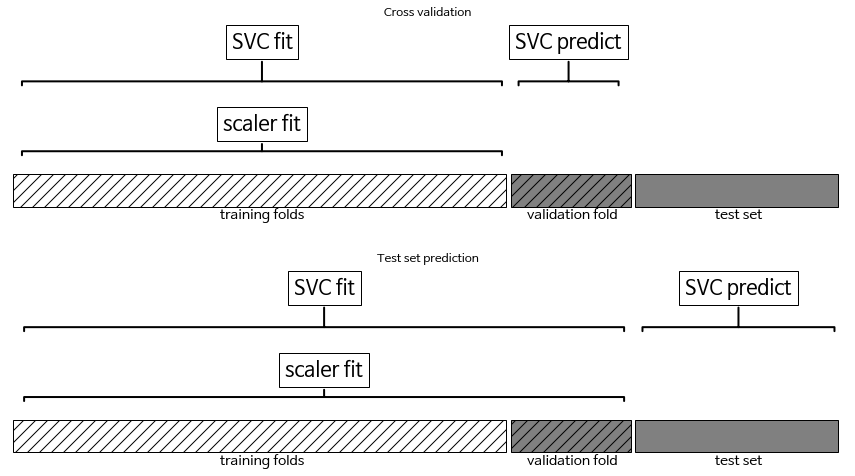

In [19]:
mglearn.plots.plot_proper_processing()

#### 정보 누설에 대한 예시

- 『The Elements of Statistical Learning』(Springer, 2016)

In [20]:
rnd = np.random.RandomState(seed=0)
X = rnd.normal(size=(100, 10000))
y = rnd.normal(size=(100,))

In [21]:
from sklearn.feature_selection import SelectPercentile, f_regression

select = SelectPercentile(score_func=f_regression, percentile=5).fit(X, y)
X_selected = select.transform(X)
print("X_selected.shape: {}".format(X_selected.shape))

X_selected.shape: (100, 500)


In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
print("교차 검증 정확도 (릿지): {:.2f}".format(
    np.mean(cross_val_score(Ridge(), X_selected, y, cv=5))))

교차 검증 정확도 (릿지): 0.91


- $R^2$로만 보면 0.91이므로 매우 좋은 모델이라고 할 수도 있음
- 그러나 교차 검증 밖에서 특성을 선택했다는 오류
- 테스트 폴드의 유출된 정보로 훈련 세트 / 테스트 세트 사이의 연관된 특성이 생김 

In [24]:
pipe = Pipeline([("select", SelectPercentile(score_func=f_regression,
                                             percentile=5)),
                 ("ridge", Ridge())])
print("교차 검증 정확도 (파이프라인): {:.2f}".format(
    np.mean(cross_val_score(pipe, X, y, cv=5))))

교차 검증 정확도 (파이프라인): -0.25


## 6.4 파이프라인 인터페이스

#### 파이프라인 세부사항 구현

- 파이프라인은 어떤 추정기와도 연결할 수 있음
- 파이프라인에 들어갈 추정기는 마지막 단계를 제외, 모두 transform 메서드를 가져야 함
- 내부적으로 Pipeline.fit 메서드가 실행되는 동안 각 단계에서 이전 단계의 transform의 출력을 입력으로 받아 fit과 transform 메서드를 차례로 호출

In [27]:
def fit(self, X, y):
    X_transformed = X
    for name, estimater in self.steps[:-1]:
        # 마지막 단계를 빼고 fit과 transform을 반복
        X_transformed = estimator.fit_transform(X_transformed, y)
    # 마지막 단계 fit 호출
    self.steps[-1][1].fit(X_transformed, y)
    return self

In [28]:
def predict(self, X):
    X_transformed = X
    for step in self.steps[:-1]:
        # 마지막 단계를 빼고 transform을 반복
        X_transformed = step[1].transform(X_transformed)
    # 마지막 단계에서 predict 호출
    return self.steps[-1][1].predict(X_transformed)

### 6.4.1 make_pipeline을 사용한 파이프라인 생성

In [29]:
from sklearn.pipeline import make_pipeline
# 표준적인 방법
pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])
# 간소화된 방법
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

- pipe_short은 단계 이름을 자동으로 만듬
- 일반적으로 단계 이름은 파이썬 클래스 이름의 소문자
- 같은 클래스를 여러 단계에서 사용하면 이름 뒤에 숫자가 추가로 붙음

In [30]:
print("파이프라인 단계:\n{}".format(pipe_short.steps))

파이프라인 단계:
[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svc', SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]


In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
print("파이프라인 단계:\n{}".format(pipe.steps))

파이프라인 단계:
[('standardscaler-1', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('standardscaler-2', StandardScaler(copy=True, with_mean=True, with_std=True))]


### 6.4.2 단계 속성에 접근하기

In [34]:
pipe.fit(cancer.data)

# named_steps 사용
components = pipe.named_steps["pca"].components_
print("components.shape: {}".format(components.shape))

components.shape: (2, 30)


### 6.4.3 그리드 서치 안의 파이프라인 속성에 접근하기

In [35]:
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(StandardScaler(), LogisticRegression())
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100]}

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print("최상의 모델:\n{}".format(grid.best_estimator_))

최상의 모델:
Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])


C:\Users\JH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  

In [39]:
print("로지스틱 회귀 단계:\n{}".format(
    grid.best_estimator_.named_steps["logisticregression"]))

로지스틱 회귀 단계:
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


In [40]:
print("로지스틱 회귀 계수:\n{}".format(
    grid.best_estimator_.named_steps["logisticregression"].coef_))

로지스틱 회귀 계수:
[[-0.38856355 -0.37529972 -0.37624793 -0.39649439 -0.11519359  0.01709608
  -0.3550729  -0.38995414 -0.05780518  0.20879795 -0.49487753 -0.0036321
  -0.37122718 -0.38337777 -0.04488715  0.19752816  0.00424822 -0.04857196
   0.21023226  0.22444999 -0.54669761 -0.52542026 -0.49881157 -0.51451071
  -0.39256847 -0.12293451 -0.38827425 -0.4169485  -0.32533663 -0.13926972]]


## 6.5 전처리와 모델의 매개변수를 위한 그리드 서치

- 파이프라인을 사용하면 머신러닝 워크플로에 필요한 모든 처리 단계를 캡슐화 할 수 있음

In [41]:
from sklearn.datasets import load_boston
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(
    boston.data, boston.target, random_state=0)

from sklearn.preprocessing import PolynomialFeatures
pipe = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(),
    Ridge())

In [42]:
param_grid = {'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

In [46]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

C:\Users\JH\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'polynomialfeatures__degree': [1, 2, 3], 'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

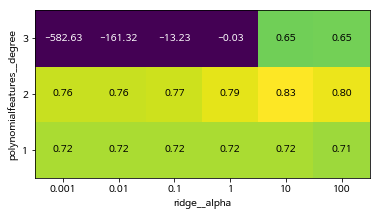

In [47]:
mglearn.tools.heatmap(grid.cv_results_['mean_test_score'].reshape(3, -1),
                     xlabel="ridge__alpha", ylabel="polynomialfeatures__degree",
                     xticklabels=param_grid['ridge__alpha'],
                     yticklabels=param_grid['polynomialfeatures__degree'], vmin=0)

In [48]:
print("최적의 매개변수: {}".format(grid.best_params_))

최적의 매개변수: {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


In [49]:
print("테스트 점수: {:.2f}".format(grid.score(X_test, y_test)))

테스트 점수: 0.77


#### 다항식 특성이 없는 그리드 서치와 비교

In [50]:
param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("다항 특성이 없을 때 점수: {:.2f}".format(grid.score(X_test, y_test)))

다항 특성이 없을 때 점수: 0.63


C:\Users\JH\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## 6.6 모델 선택을 위한 그리드 서치

- 파이프라인을 구성하는 단계도 탐색 대상으로 삼을 수 있음

In [51]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

from sklearn.ensemble import RandomForestClassifier

param_grid = [
    {'classifier': [SVC()], 'preprocessing': [StandardScaler()],
     'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'classifier': [RandomForestClassifier(n_estimators=100)],
     'preprocessing': [None], 'classifier__max_features': [1, 2, 3]}]

In [53]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print("최적의 매개변수:\n{}\n".format(grid.best_params_))
print("최상의 교차 검증 점수: {:.2f}".format(grid.best_score_))
print("테스트 점수: {:.2f}".format(grid.score(X_test, y_test)))

최적의 매개변수:
{'classifier': SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}

최상의 교차 검증 점수: 0.99
테스트 점수: 0.98


## 6.7 요약 및 정리